# VI. Machine Learning Part I: The Tools

## Regression

Regression is a series of statistical tools to find the equation of a function which best fits some scattered data. We will generate data with an underlying trend, make a guess of this trend, and devise an iteration to improve this guess.

#### A Linear Trend

We will start with the simplest case in the book: a linear pattern. This is a chance for us to become acquainted with some of the fundamental working part of a neural network, which we will implement shortly.

First we import some tools:

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

We will begin by encoding the equation of a line
$$y=mx+b,$$
as a python function.

In [2]:
def linear(x, m, b): return m*x+b

For validation, rather than using real data, we will generate our own. First we will fix the parameters of the linear equation; we will use capital letters, $M$ and $B$, to distinguish the *real* parameters from the *estimated* ones later.

In [3]:
M = 3
B = 1

Now, we generate the data. First, we make an array of $N$ values of the $x$-coordinate, $X_i$:

In [4]:
N = 200
X = rand(N)

We will first define $L_i=mX_i+b$, the $y$-values which truly satisfy the linear relation. Then, we define noisy $y$-values by $Y_i=L_i+\sigma Z_i$, where $Z_i\sim U(-1,1)$, a uniform random variable.

In [5]:
L = linear(X, M, B)

sigma = 0.4
Y = L + (rand(N)*2-1)*sigma

#### Plotting The Data

We now have pairs $(X_i, Y_i)$ which represent data with a noisy linear trend. We can plot the pairs over the linear equation to visualise the trend with the following code:

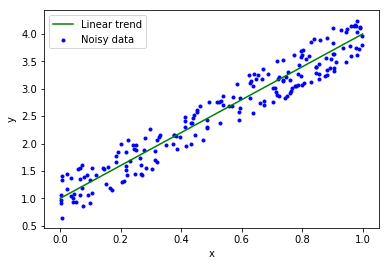

In [6]:
#Scatter plot
plt.scatter(X, Y, c='b', marker='.')

#Line plot
t = np.linspace(0,1,100)
plt.plot(t, linear(t, M, B), c='g')

#Labels
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Linear trend", "Noisy data"])

The first line simply makes a scatter plot of the $(X_i, Y_i)$ pairs, in blue. To plot the linear trend we create an array of ordered $x$-coordinates, `t`, using the `np.linspace` function; then we plot the `linear` function applied to `t` to present a "continuous" line.

#### Guessing the Trend

The data is noisy as intended, but the linear trend is clear. Suppose now we didn't know the values of $M$ and $B$. How could we approximate them? What we will do is, as usual, begin with a guess and come up with a way of improving it iteratively. First we guess approximate values of $M$ and $B$, and we call them $m$ and $b$:

In [7]:
m = -5
b = 10

We can now apply the linear equation with parameters $m$ and $b$ to $X_i$ to obtain our guesses for the $y$-coordinate, $y_i$. If our guess is good, the values of $y_i$ will be *close* to the real ordinates $Y_i$.

In [8]:
y = linear(X, m, b)

#### Comparing the Trends

We could show these values as a scatter plot, but the comparison is easier if we simply add the line with coefficients $m$ and $b$ to our previous plot.

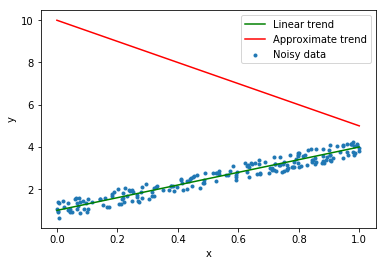

In [9]:
#Previous plots
plt.scatter(X, Y, marker='.')
plt.plot(t, linear(t, M, B), 'g')

#New plots
plt.plot(t, linear(t, m, b), 'r')

#Labels
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Linear trend", "Approximate trend", "Noisy data"])

Our initial guess for the trend is plotted in red, whereas the real trend is plotted in green. If you picked $m$ and $b$ somewhat randomly, the guess is probably not a very good one. We will now work to improve this.

#### The Loss Function

The first thing to do is to quantify the quality of the approximation. We need a numerical value, a **score**, which lets us compare different guesses; this is sometimes called a *cost function*, an *objective function*, or a **loss function**.

A typical loss function for trend estimation is the [*mean squared error* (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error):
$$
\mathcal{J} = \frac{1}{N}\sum_{i=1}^{N}(Y_i-y_i)^2 = \frac{1}{N}\sum_{i=1}^{N}(Y_i-mX_i-b)^2.
$$
This is a nice choice of loss function for a number of reasons. For instance, squaring the error makes small deviations even smaller whilst enlarging deviations greater than $1$. In a way, this loss function puts the emphasis on large erros and "forgives" the smaller deviations; it does not matter if the guess is inexact as long as no point is missed by a large margin. This is important because the noisy data is *not* exactly linear, even though it is *close* to linear.

We can define the `loss` function succinctly with a list comprehension and test the loss of the current guess:

In [10]:
def loss(N, y, X, Y): return sum([(Y[k]-y[k])**2 for k in range(0, N)])/N

In [11]:
loss(N, y, X, Y)

28.856114435747084

#### Minima of the Loss Function

Now that we have a guess and its corresponding score, we should try to improve it. Another of the nice properties of the MSE loss function is that it is differentiable with respect to the parameters $m$ and $b$. We can compute the derivatives explicitly. By recalling the cost
\begin{align}
\mathcal{J} = \frac{1}{N}\sum_{i=1}^{N}(Y_i-y_i)^2 = \frac{1}{N}\sum_{i=1}^{N}(Y_i-mX_i-b)^2,
\end{align}
we obtain
\begin{align}
\frac{\partial\mathcal{J}}{\partial m}
& = \frac{-2}{N}\sum_{i=1}^{N}(Y_i-mX_i-b)X_i
= \frac{-2}{N}\sum_{i=1}^{N}(Y_i-y_i)X_i,
\\\frac{\partial\mathcal{J}}{\partial b}
& = \frac{-2}{N}\sum_{i=1}^{N}(Y_i-mX_i-b)
= \frac{-2}{N}\sum_{i=1}^{N}(Y_i-y_i).
\end{align}
Both of these derivatives should be zero once we find the minimisers of the loss function, i.e. the values of $m$ and $b$ which yield a minimum of the error. We will not consider the issue of several minima for now.

We can implement functions for the derivatives and check their current value:

In [12]:
def mDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k])*X[k] for k in range(0, N)])/N
def bDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k]) for k in range(0, N)])/N

In [13]:
mDerivative(N, y, X, Y)

3.543423514817003

In [14]:
bDerivative(N, y, X, Y)

9.548800932659116

#### Gradient Descent

The current derivatives are far from being zero, which means the loss is far from being minimal. We can use gradient descent to update our guesses.

In general, gradient descent is a method for finding a minimum of a function. If we are trying to minimise a function $f:\mathbb{R}^n\rightarrow \mathbb{R}$, we begin with an initial guess $x_0\in\mathbb{R}^n$ and compute the gradient of $f$ at that point, $\nabla f(x_0)$. We then update our guess by
$$
x_1 = x_0 - s_0\nabla f(x_0)
$$
for some positive constant $s_0$. In general, the iteration is
$$
x_{n+1} = x_n - s_n\nabla f(x_n).
$$
Note that if $f$ takes only a real argument, the gradient is simply the derivative:
$$
x_{n+1} = x_n - s_n\frac{\mathrm{d}f}{\mathrm{d}x}(x_n).
$$
The $s_n$ have to be chosen small enough to ensure that $f(x_{n+1})\leq f(x_{n})$. A typical approach is to fix $s$ and begin the descent checking that $f(x_{n+1})\leq f(x_{n})$ at every step. As soon as $f(x_{n+1})>f(x_{n})$, the current $s$ is rejected and a new, smaller constant is chosen.

In our case, thinking of $\mathcal{J}$ as a function of $m$ and $b$, the gradient is
$$
\nabla\mathcal{J}=\left(\frac{\partial\mathcal{J}}{\partial m},\frac{\partial\mathcal{J}}{\partial b}\right).
$$
The iteration will look like
$$
\left(m_{n+1},b_{n+1}\right)
= \left(m_{n},b_{n}\right)
- s_n\left(\frac{\partial\mathcal{J}}{\partial m},\frac{\partial\mathcal{J}}{\partial b}\right)
,
$$
which can be done separately for $m$ and for $b$ as
\begin{align}
m_{n+1} &= m_{n}- s_n\frac{\partial\mathcal{J}}{\partial m},
\\b_{n+1} &= b_{n}- s_n\frac{\partial\mathcal{J}}{\partial b}.
\end{align}

Like every iteration, we will need a stopping criterion. We will select a tolerance $\varepsilon$ and stop whenever $\left|\frac{\partial\mathcal{J}}{\partial m}\right|<\varepsilon$ and $\left|\frac{\partial\mathcal{J}}{\partial b}\right|<\varepsilon$.

We will now implement the descent algorithm, storing each value of the loss in a list `lossList` to plot it later.

In [15]:
m = -5
b = 10

y = linear(X, m, b)

s = 1000
tol = 1.0e-8

lossCurrent = loss(N, y, X, Y)
lossList = [lossCurrent]

for k in range(0, 1000):
    mDer = mDerivative(N, y, X, Y)
    bDer = bDerivative(N, y, X, Y)
    
    mDerAbs = abs(mDer)
    bDerAbs = abs(bDer)
    
    mNew = m - s*mDer
    bNew = b - s*bDer
    
    yNew = linear(X, mNew, bNew)

    lossNew = loss(N, yNew, X, Y)

    if lossNew > lossCurrent:
        s = s/2
        print(f"k = {k}, descent failed. New step = {s}")
    else:
        m = mNew
        b = bNew
        y = yNew
        
        lossCurrent = lossNew
        lossList.append(lossCurrent)
        print(f"k = {k}. Loss = {lossNew}. Derivatives = {mDerAbs}, {bDerAbs}.")
    
    if mDerAbs<tol and bDerAbs<tol:
        break

print(f"\n True values: M = {M}, B = {B}. Approximate values: m = {m}, b = {b}")

k = 0, descent failed. New step = 500.0
k = 1, descent failed. New step = 250.0
k = 2, descent failed. New step = 125.0
k = 3, descent failed. New step = 62.5
k = 4, descent failed. New step = 31.25
k = 5, descent failed. New step = 15.625
k = 6, descent failed. New step = 7.8125
k = 7, descent failed. New step = 3.90625
k = 8, descent failed. New step = 1.953125
k = 9, descent failed. New step = 0.9765625
k = 10, descent failed. New step = 0.48828125
k = 11. Loss = 9.614838531156797. Derivatives = 3.543423514817003, 9.548800932659116.
k = 12. Loss = 7.163933262840616. Derivatives = 2.6973573062148852, 1.6091343984823987.
k = 13. Loss = 6.0989198702157195. Derivatives = 0.8743257956601898, 1.3575690419292865.
k = 14. Loss = 5.258582741443345. Derivatives = 1.2554513771047209, 0.4840873731889567.
k = 15. Loss = 4.540021228589711. Derivatives = 1.0447677646332125, 0.660762959640912.
k = 16. Loss = 3.9210949608882726. Derivatives = 1.0028525631239977, 0.5559218321896444.
k = 17. Loss = 3.

We have convergence! The optimal values of $m$ and $b$ we recover might be a little different from $M$ and $B$, both because we only have an approximation, but also because the *true* linear trend of the data might be slightly different from the trend given by $M$ and $B$ since we only have a finite number of samples.

We can plot the estimated trend to see whether or not it captures the trend:

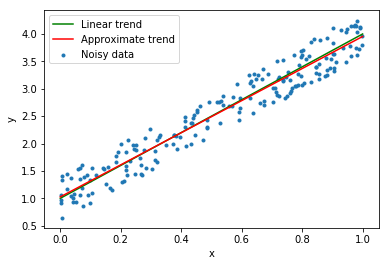

In [16]:
plt.scatter(X, Y, marker='.')
plt.plot(t, linear(t, M, B), 'g')
plt.plot(t, linear(t, m, b), 'r')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Linear trend", "Approximate trend", "Noisy data"])

We can also plot the `lossList` over the number of iterations to see how it has decreased:

Text(0, 0.5, 'Loss')

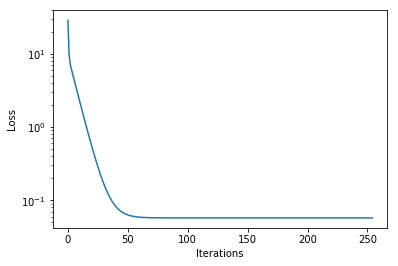

In [17]:
plt.semilogy(range(0,len(lossList)),lossList)

plt.xlabel("Iterations")
plt.ylabel("Loss")

### Non-Linear Regression

The problem we have just considered, often called the [Linear Least Squares problem](https://en.wikipedia.org/wiki/Linear_least_squares), actually has an exact solution, easy to compute but not so easy to justify. However, the gradient descent method we have used is more general, and will let us deal with non-linear data as well.

This time we are going to assume the data has a quadratic trend, given by
$$
y = ax^2+bx+c.
$$
To generate some validation data, we will define the quadratic:

In [18]:
def quadratic(x, a, b, c): return a*x**2 + b*x + c

We choose the quadratic $10x^2-10x+5$, simply because it has a nice shape on the interval $[0,1]$. We define the true parameters, $A, B, C$:

In [19]:
A = 10
B = -10
C = 5

Again, we generate random $x$-coordinates $X_i$,

In [20]:
N = 200
X = rand(N)

and we also generate the true quadratic values $L_i=AX_i^2+BX_i+C$ as well as the noisy values $Y_i=L_i+\sigma Z_i$:

In [21]:
L = quadratic(X, A, B, C)

sigma = 0.3
Y = L + (rand(N)*2-1)*sigma

We proceed to plot the trend:

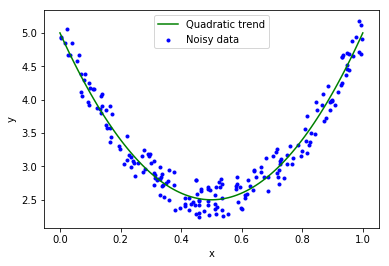

In [22]:
#Scatter plot
plt.scatter(X, Y, c='b', marker='.')

#Quadratic plot
t = np.linspace(0,1,100)
plt.plot(t, quadratic(t, A, B, C), c='g')

#Labels
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Quadratic trend", "Noisy data"])

Now we are ready to make a guess, define the loss function, compute its derivatives and descend its gradient.
 
We can initialise the approximate parameters to anything in practice. As we saw before, the quadratic error causes the loss function to decrease rapidly at the beginning; the parameters will rapidly become *close* to the real ones, even if full convergence will take longer.

In [23]:
a = (rand()*2-1)*10
b = (rand()*2-1)*10
c = (rand()*2-1)*10

Once again we can evaluate the $y$-coordinates corresponding to our current guess and plot the guessed quadratic trend to compare.

In [24]:
y = quadratic(X, a, b, c)

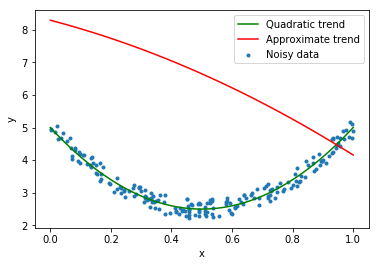

In [25]:
plt.scatter(X, Y, marker='.')
plt.plot(t, quadratic(t, A, B, C), 'g')
plt.plot(t, quadratic(t, a, b, c), 'r')

#Labels
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Quadratic trend", "Approximate trend", "Noisy data"])

We will again define a MSE loss function,
$$
\mathcal{J} = \frac{1}{N}\sum_{i=1}^{N}(Y_i-y_i)^2 = \frac{1}{N}\sum_{i=1}^{N}\left[Y_i-(aX_i^2+bX_i+c)\right]^2,
$$
and compute its derivatives with respect to $a, b$ and $c$:
\begin{align}
\frac{\partial\mathcal{J}}{\partial a}
& = \frac{-2}{N}\sum_{i=1}^{N}\left[Y_i-(aX_i^2+bX_i+c)\right]X_i^2
= \frac{-2}{N}\sum_{i=1}^{N}(Y_i-y_i)X_i^2
,\\\frac{\partial\mathcal{J}}{\partial b}
& = \frac{-2}{N}\sum_{i=1}^{N}\left[Y_i-(aX_i^2+bX_i+c)\right]X_i
= \frac{-2}{N}\sum_{i=1}^{N}(Y_i-y_i)X_i
,\\\frac{\partial\mathcal{J}}{\partial c}
& = \frac{-2}{N}\sum_{i=1}^{N}\left[Y_i-(aX_i^2+bX_i+c)\right]
= \frac{-2}{N}\sum_{i=1}^{N}(Y_i-y_i)
.
\end{align}

We can implement these &mdash; in fact we can recycle some of the code from the linear regression section!

In [26]:
def loss(N, y, X, Y): return sum([(Y[k]-y[k])**2 for k in range(0, N)])/N

In [27]:
def aDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k])*X[k]**2 for k in range(0, N)])/N
def bDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k])*X[k] for k in range(0, N)])/N
def cDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k]) for k in range(0, N)])/N

The gradient descent algorithm for the problem looks very similar to the previous one:
\begin{align}
a_{n+1} &= a_{n}- s_n\frac{\partial\mathcal{J}}{\partial a},
\\b_{n+1} &= b_{n}- s_n\frac{\partial\mathcal{J}}{\partial b},
\\c_{n+1} &= c_{n}- s_n\frac{\partial\mathcal{J}}{\partial c}.
\end{align}

All that remains now is the gradient descent loop, which will also look very similar to the previous loop:

In [28]:
a = (rand()*2-1)*10
b = (rand()*2-1)*10
c = (rand()*2-1)*10

y = quadratic(X, a, b, c)

s = 1000
tol = 1.0e-8

lossCurrent = loss(N, y, X, Y)
lossList = [lossCurrent]

for k in range(0, 10000):
    aDer = aDerivative(N, y, X, Y)
    bDer = bDerivative(N, y, X, Y)
    cDer = cDerivative(N, y, X, Y)
    
    aDerAbs = abs(aDer)
    bDerAbs = abs(bDer)
    cDerAbs = abs(cDer)
    
    aNew = a - s*aDer
    bNew = b - s*bDer
    cNew = c - s*cDer
    
    yNew = quadratic(X, aNew, bNew, cNew)

    lossNew = loss(N, yNew, X, Y)

    if lossNew > lossCurrent:
        s = s/2
        print(f"k = {k}, descent failed. New step = {s}")
    else:
        a = aNew
        b = bNew
        c = cNew

        y = yNew
        
        lossCurrent = lossNew
        lossList.append(lossCurrent)
        print(f"k = {k}. Loss = {lossNew}.")
    
    if aDerAbs<tol and bDerAbs<tol and cDerAbs<tol:
        break

print(f"\n True values: A = {A}, B = {B}, C = {C}.")
print(f"\n Approximate values: a = {a}, b = {b}, c = {c}.")

k = 0, descent failed. New step = 500.0
k = 1, descent failed. New step = 250.0
k = 2, descent failed. New step = 125.0
k = 3, descent failed. New step = 62.5
k = 4, descent failed. New step = 31.25
k = 5, descent failed. New step = 15.625
k = 6, descent failed. New step = 7.8125
k = 7, descent failed. New step = 3.90625
k = 8, descent failed. New step = 1.953125
k = 9, descent failed. New step = 0.9765625
k = 10, descent failed. New step = 0.48828125
k = 11. Loss = 29.821463859446634.
k = 12. Loss = 10.144502571331182.
k = 13. Loss = 6.034412289318787.
k = 14. Loss = 4.469303982050872.
k = 15. Loss = 3.488707386338119.
k = 16. Loss = 2.7594620741513376.
k = 17. Loss = 2.196256574637473.
k = 18. Loss = 1.7580535575341332.
k = 19. Loss = 1.4165941370186184.
k = 20. Loss = 1.1504059811852931.
k = 21. Loss = 0.9428412378685214.
k = 22. Loss = 0.7809428544364927.
k = 23. Loss = 0.6546190471587526.
k = 24. Loss = 0.5560086223466694.
k = 25. Loss = 0.4789877918979722.
k = 26. Loss = 0.418786

k = 250. Loss = 0.08612543937000794.
k = 251. Loss = 0.08583316531876052.
k = 252. Loss = 0.08554239815779648.
k = 253. Loss = 0.08525313011797453.
k = 254. Loss = 0.08496535347020957.
k = 255. Loss = 0.08467906052526537.
k = 256. Loss = 0.08439424363354946.
k = 257. Loss = 0.08411089518490876.
k = 258. Loss = 0.08382900760842632.
k = 259. Loss = 0.08354857337221876.
k = 260. Loss = 0.0832695849832351.
k = 261. Loss = 0.08299203498705685.
k = 262. Loss = 0.0827159159676984.
k = 263. Loss = 0.08244122054740899.
k = 264. Loss = 0.08216794138647593.
k = 265. Loss = 0.08189607118302816.
k = 266. Loss = 0.08162560267284084.
k = 267. Loss = 0.08135652862914214.
k = 268. Loss = 0.08108884186241924.
k = 269. Loss = 0.08082253522022669.
k = 270. Loss = 0.08055760158699533.
k = 271. Loss = 0.0802940338838421.
k = 272. Loss = 0.08003182506838058.
k = 273. Loss = 0.07977096813453334.
k = 274. Loss = 0.07951145611234428.
k = 275. Loss = 0.07925328206779293.
k = 276. Loss = 0.07899643910260855.
k = 

k = 511. Loss = 0.0441452906835495.
k = 512. Loss = 0.04406945554597.
k = 513. Loss = 0.043994011394971215.
k = 514. Loss = 0.04391895621472642.
k = 515. Loss = 0.04384428799980181.
k = 516. Loss = 0.043770004755103065.
k = 517. Loss = 0.04369610449582226.
k = 518. Loss = 0.04362258524738434.
k = 519. Loss = 0.04354944504539491.
k = 520. Loss = 0.04347668193558735.
k = 521. Loss = 0.04340429397377079.
k = 522. Loss = 0.0433322792257781.
k = 523. Loss = 0.043260635767414284.
k = 524. Loss = 0.043189361684404876.
k = 525. Loss = 0.04311845507234495.
k = 526. Loss = 0.04304791403664826.
k = 527. Loss = 0.04297773669249667.
k = 528. Loss = 0.0429079211647894.
k = 529. Loss = 0.042838465588093406.
k = 530. Loss = 0.0427693681065934.
k = 531. Loss = 0.04270062687404199.
k = 532. Loss = 0.04263224005371066.
k = 533. Loss = 0.04256420581834077.
k = 534. Loss = 0.042496522350094226.
k = 535. Loss = 0.042429187840505526.
k = 536. Loss = 0.042362200490433086.
k = 537. Loss = 0.042295558510011065.

k = 986. Loss = 0.030698981701422462.
k = 987. Loss = 0.030692472295170633.
k = 988. Loss = 0.03068599644975318.
k = 989. Loss = 0.030679553992139036.
k = 990. Loss = 0.03067314475018923.
k = 991. Loss = 0.03066676855265229.
k = 992. Loss = 0.030660425229159655.
k = 993. Loss = 0.030654114610221158.
k = 994. Loss = 0.03064783652722047.
k = 995. Loss = 0.030641590812410704.
k = 996. Loss = 0.030635377298909597.
k = 997. Loss = 0.030629195820695565.
k = 998. Loss = 0.03062304621260278.
k = 999. Loss = 0.03061692831031706.
k = 1000. Loss = 0.030610841950371396.
k = 1001. Loss = 0.030604786970141466.
k = 1002. Loss = 0.030598763207841627.
k = 1003. Loss = 0.030592770502520062.
k = 1004. Loss = 0.030586808694054994.
k = 1005. Loss = 0.030580877623150156.
k = 1006. Loss = 0.030574977131330536.
k = 1007. Loss = 0.030569107060938155.
k = 1008. Loss = 0.030563267255127903.
k = 1009. Loss = 0.030557457557863404.
k = 1010. Loss = 0.03055167781391265.
k = 1011. Loss = 0.03054592786884396.
k = 1012

k = 1226. Loss = 0.029801579169132068.
k = 1227. Loss = 0.02979969654090006.
k = 1228. Loss = 0.029797823619017897.
k = 1229. Loss = 0.029795960353442084.
k = 1230. Loss = 0.02979410669438722.
k = 1231. Loss = 0.029792262592324543.
k = 1232. Loss = 0.029790427997980623.
k = 1233. Loss = 0.029788602862336085.
k = 1234. Loss = 0.029786787136624283.
k = 1235. Loss = 0.029784980772330053.
k = 1236. Loss = 0.029783183721188277.
k = 1237. Loss = 0.029781395935182732.
k = 1238. Loss = 0.029779617366544792.
k = 1239. Loss = 0.029777847967752.
k = 1240. Loss = 0.029776087691527012.
k = 1241. Loss = 0.029774336490836183.
k = 1242. Loss = 0.029772594318888422.
k = 1243. Loss = 0.02977086112913377.
k = 1244. Loss = 0.029769136875262378.
k = 1245. Loss = 0.02976742151120315.
k = 1246. Loss = 0.02976571499112242.
k = 1247. Loss = 0.029764017269422915.
k = 1248. Loss = 0.02976232830074247.
k = 1249. Loss = 0.029760648039952677.
k = 1250. Loss = 0.02975897644215801.
k = 1251. Loss = 0.0297573134626941

k = 1498. Loss = 0.029525935090978325.
k = 1499. Loss = 0.029525473613140063.
k = 1500. Loss = 0.029525014514563533.
k = 1501. Loss = 0.02952455778298189.
k = 1502. Loss = 0.029524103406191504.
k = 1503. Loss = 0.02952365137205168.
k = 1504. Loss = 0.029523201668484305.
k = 1505. Loss = 0.029522754283473597.
k = 1506. Loss = 0.029522309205065565.
k = 1507. Loss = 0.029521866421368045.
k = 1508. Loss = 0.02952142592055004.
k = 1509. Loss = 0.02952098769084165.
k = 1510. Loss = 0.029520551720533594.
k = 1511. Loss = 0.029520117997976963.
k = 1512. Loss = 0.029519686511582953.
k = 1513. Loss = 0.02951925724982247.
k = 1514. Loss = 0.02951883020122587.
k = 1515. Loss = 0.029518405354382687.
k = 1516. Loss = 0.029517982697941182.
k = 1517. Loss = 0.029517562220608248.
k = 1518. Loss = 0.029517143911148885.
k = 1519. Loss = 0.02951672775838624.
k = 1520. Loss = 0.029516313751200767.
k = 1521. Loss = 0.02951590187853051.
k = 1522. Loss = 0.029515492129370453.
k = 1523. Loss = 0.02951508449277

k = 1822. Loss = 0.02945319672054013.
k = 1823. Loss = 0.02945311026314301.
k = 1824. Loss = 0.029453024251498084.
k = 1825. Loss = 0.02945293868330725.
k = 1826. Loss = 0.029452853556284086.
k = 1827. Loss = 0.029452768868154167.
k = 1828. Loss = 0.02945268461665454.
k = 1829. Loss = 0.029452600799534108.
k = 1830. Loss = 0.029452517414553327.
k = 1831. Loss = 0.029452434459484155.
k = 1832. Loss = 0.029452351932110172.
k = 1833. Loss = 0.029452269830226176.
k = 1834. Loss = 0.02945218815163853.
k = 1835. Loss = 0.029452106894164796.
k = 1836. Loss = 0.02945202605563381.
k = 1837. Loss = 0.029451945633885614.
k = 1838. Loss = 0.029451865626771382.
k = 1839. Loss = 0.029451786032153465.
k = 1840. Loss = 0.029451706847904963.
k = 1841. Loss = 0.0294516280719102.
k = 1842. Loss = 0.029451549702064365.
k = 1843. Loss = 0.029451471736273396.
k = 1844. Loss = 0.029451394172454126.
k = 1845. Loss = 0.029451317008534015.
k = 1846. Loss = 0.029451240242451444.
k = 1847. Loss = 0.02945116387215

k = 2049. Loss = 0.029441614598363152.
k = 2050. Loss = 0.02944158785542678.
k = 2051. Loss = 0.0294415612503702.
k = 2052. Loss = 0.02944153478248244.
k = 2053. Loss = 0.029441508451056354.
k = 2054. Loss = 0.029441482255388358.
k = 2055. Loss = 0.02944145619477853.
k = 2056. Loss = 0.029441430268530553.
k = 2057. Loss = 0.02944140447595168.
k = 2058. Loss = 0.02944137881635275.
k = 2059. Loss = 0.029441353289048126.
k = 2060. Loss = 0.029441327893355847.
k = 2061. Loss = 0.02944130262859715.
k = 2062. Loss = 0.029441277494097126.
k = 2063. Loss = 0.0294412524891842.
k = 2064. Loss = 0.029441227613190166.
k = 2065. Loss = 0.029441202865450423.
k = 2066. Loss = 0.029441178245303696.
k = 2067. Loss = 0.029441153752092154.
k = 2068. Loss = 0.029441129385161333.
k = 2069. Loss = 0.02944110514386019.
k = 2070. Loss = 0.029441081027540995.
k = 2071. Loss = 0.02944105703555937.
k = 2072. Loss = 0.02944103316727425.
k = 2073. Loss = 0.029441009422047904.
k = 2074. Loss = 0.02944098579924595.


k = 2292. Loss = 0.029437904668223668.
k = 2293. Loss = 0.02943789705273854.
k = 2294. Loss = 0.02943788947651699.
k = 2295. Loss = 0.0294378819393565.
k = 2296. Loss = 0.029437874441055615.
k = 2297. Loss = 0.029437866981414092.
k = 2298. Loss = 0.029437859560232576.
k = 2299. Loss = 0.029437852177312797.
k = 2300. Loss = 0.029437844832457438.
k = 2301. Loss = 0.02943783752547028.
k = 2302. Loss = 0.029437830256156053.
k = 2303. Loss = 0.029437823024320603.
k = 2304. Loss = 0.029437815829770623.
k = 2305. Loss = 0.029437808672313874.
k = 2306. Loss = 0.029437801551759193.
k = 2307. Loss = 0.029437794467916265.
k = 2308. Loss = 0.02943778742059577.
k = 2309. Loss = 0.029437780409609496.
k = 2310. Loss = 0.02943777343477007.
k = 2311. Loss = 0.029437766495891086.
k = 2312. Loss = 0.02943775959278729.
k = 2313. Loss = 0.02943775272527406.
k = 2314. Loss = 0.02943774589316802.
k = 2315. Loss = 0.02943773909628649.
k = 2316. Loss = 0.029437732334447988.
k = 2317. Loss = 0.02943772560747185

k = 2608. Loss = 0.029436715995069692.
k = 2609. Loss = 0.029436714508079526.
k = 2610. Loss = 0.029436713028755845.
k = 2611. Loss = 0.02943671155705924.
k = 2612. Loss = 0.029436710092950277.
k = 2613. Loss = 0.029436708636389898.
k = 2614. Loss = 0.029436707187339196.
k = 2615. Loss = 0.029436705745759392.
k = 2616. Loss = 0.029436704311611987.
k = 2617. Loss = 0.029436702884858758.
k = 2618. Loss = 0.029436701465461453.
k = 2619. Loss = 0.029436700053382166.
k = 2620. Loss = 0.02943669864858326.
k = 2621. Loss = 0.029436697251027114.
k = 2622. Loss = 0.02943669586067641.
k = 2623. Loss = 0.029436694477493995.
k = 2624. Loss = 0.029436693101442896.
k = 2625. Loss = 0.02943669173248642.
k = 2626. Loss = 0.029436690370587878.
k = 2627. Loss = 0.02943668901571095.
k = 2628. Loss = 0.02943668766781942.
k = 2629. Loss = 0.02943668632687732.
k = 2630. Loss = 0.029436684992848745.
k = 2631. Loss = 0.02943668366569806.
k = 2632. Loss = 0.029436682345389823.
k = 2633. Loss = 0.02943668103188

k = 3000. Loss = 0.02943646560102644.
k = 3001. Loss = 0.029436465405003873.
k = 3002. Loss = 0.02943646520999201.
k = 3003. Loss = 0.029436465015985517.
k = 3004. Loss = 0.029436464822979347.
k = 3005. Loss = 0.02943646463096824.
k = 3006. Loss = 0.02943646443994709.
k = 3007. Loss = 0.029436464249910782.
k = 3008. Loss = 0.02943646406085425.
k = 3009. Loss = 0.029436463872772486.
k = 3010. Loss = 0.029436463685660393.
k = 3011. Loss = 0.02943646349951299.
k = 3012. Loss = 0.029436463314325326.
k = 3013. Loss = 0.029436463130092454.
k = 3014. Loss = 0.02943646294680942.
k = 3015. Loss = 0.02943646276447138.
k = 3016. Loss = 0.02943646258307342.
k = 3017. Loss = 0.02943646240261066.
k = 3018. Loss = 0.02943646222307837.
k = 3019. Loss = 0.02943646204447167.
k = 3020. Loss = 0.029436461866785824.
k = 3021. Loss = 0.029436461690016073.
k = 3022. Loss = 0.029436461514157738.
k = 3023. Loss = 0.029436461339206067.
k = 3024. Loss = 0.029436461165156348.
k = 3025. Loss = 0.029436460992004095

k = 3259. Loss = 0.029436437548270914.
k = 3260. Loss = 0.029436437496881195.
k = 3261. Loss = 0.029436437445756483.
k = 3262. Loss = 0.0294364373948953.
k = 3263. Loss = 0.02943643734429638.
k = 3264. Loss = 0.029436437293958326.
k = 3265. Loss = 0.029436437243879836.
k = 3266. Loss = 0.029436437194059487.
k = 3267. Loss = 0.029436437144495984.
k = 3268. Loss = 0.029436437095188072.
k = 3269. Loss = 0.029436437046134366.
k = 3270. Loss = 0.029436436997333573.
k = 3271. Loss = 0.029436436948784377.
k = 3272. Loss = 0.029436436900485478.
k = 3273. Loss = 0.02943643685243559.
k = 3274. Loss = 0.02943643680463344.
k = 3275. Loss = 0.029436436757077744.
k = 3276. Loss = 0.029436436709767252.
k = 3277. Loss = 0.02943643666270067.
k = 3278. Loss = 0.029436436615876756.
k = 3279. Loss = 0.029436436569294247.
k = 3280. Loss = 0.029436436522951914.
k = 3281. Loss = 0.029436436476848536.
k = 3282. Loss = 0.029436436430982788.
k = 3283. Loss = 0.02943643638535357.
k = 3284. Loss = 0.0294364363399

k = 3937. Loss = 0.029436427880406676.
k = 3938. Loss = 0.029436427878862012.
k = 3939. Loss = 0.029436427877325314.
k = 3940. Loss = 0.029436427875796527.
k = 3941. Loss = 0.02943642787427563.
k = 3942. Loss = 0.029436427872762617.
k = 3943. Loss = 0.02943642787125736.
k = 3944. Loss = 0.029436427869759873.
k = 3945. Loss = 0.029436427868270103.
k = 3946. Loss = 0.02943642786678802.
k = 3947. Loss = 0.02943642786531359.
k = 3948. Loss = 0.029436427863846745.
k = 3949. Loss = 0.029436427862387475.
k = 3950. Loss = 0.02943642786093572.
k = 3951. Loss = 0.02943642785949145.
k = 3952. Loss = 0.02943642785805466.
k = 3953. Loss = 0.029436427856625206.
k = 3954. Loss = 0.029436427855203163.
k = 3955. Loss = 0.029436427853788468.
k = 3956. Loss = 0.02943642785238105.
k = 3957. Loss = 0.02943642785098087.
k = 3958. Loss = 0.029436427849587932.
k = 3959. Loss = 0.029436427848202173.
k = 3960. Loss = 0.029436427846823574.
k = 3961. Loss = 0.02943642784545202.
k = 3962. Loss = 0.0294364278440875

k = 4190. Loss = 0.029436427661825436.
k = 4191. Loss = 0.02943642766140774.
k = 4192. Loss = 0.02943642766099216.
k = 4193. Loss = 0.02943642766057875.
k = 4194. Loss = 0.029436427660167498.
k = 4195. Loss = 0.029436427659758357.
k = 4196. Loss = 0.02943642765935127.
k = 4197. Loss = 0.029436427658946305.
k = 4198. Loss = 0.02943642765854347.
k = 4199. Loss = 0.029436427658142666.
k = 4200. Loss = 0.02943642765774397.
k = 4201. Loss = 0.02943642765734732.
k = 4202. Loss = 0.029436427656952698.
k = 4203. Loss = 0.0294364276565601.
k = 4204. Loss = 0.029436427656169543.
k = 4205. Loss = 0.029436427655780997.
k = 4206. Loss = 0.029436427655394434.
k = 4207. Loss = 0.02943642765500988.
k = 4208. Loss = 0.029436427654627333.
k = 4209. Loss = 0.029436427654246727.
k = 4210. Loss = 0.029436427653868114.
k = 4211. Loss = 0.029436427653491446.
k = 4212. Loss = 0.029436427653116694.
k = 4213. Loss = 0.02943642765274387.
k = 4214. Loss = 0.02943642765237298.
k = 4215. Loss = 0.029436427652004007

k = 4472. Loss = 0.029436427599666696.
k = 4473. Loss = 0.029436427599569485.
k = 4474. Loss = 0.029436427599472768.
k = 4475. Loss = 0.029436427599376508.
k = 4476. Loss = 0.029436427599280796.
k = 4477. Loss = 0.029436427599185525.
k = 4478. Loss = 0.0294364275990908.
k = 4479. Loss = 0.02943642759899653.
k = 4480. Loss = 0.029436427598902776.
k = 4481. Loss = 0.029436427598809448.
k = 4482. Loss = 0.02943642759871666.
k = 4483. Loss = 0.029436427598624307.
k = 4484. Loss = 0.029436427598532485.
k = 4485. Loss = 0.029436427598441086.
k = 4486. Loss = 0.029436427598350138.
k = 4487. Loss = 0.02943642759825972.
k = 4488. Loss = 0.029436427598169734.
k = 4489. Loss = 0.029436427598080215.
k = 4490. Loss = 0.029436427597991154.
k = 4491. Loss = 0.029436427597902576.
k = 4492. Loss = 0.029436427597814462.
k = 4493. Loss = 0.02943642759772677.
k = 4494. Loss = 0.02943642759763954.
k = 4495. Loss = 0.02943642759755275.
k = 4496. Loss = 0.029436427597466435.
k = 4497. Loss = 0.02943642759738

k = 4815. Loss = 0.029436427584010473.
k = 4816. Loss = 0.02943642758399399.
k = 4817. Loss = 0.029436427583977545.
k = 4818. Loss = 0.02943642758396122.
k = 4819. Loss = 0.029436427583944953.
k = 4820. Loss = 0.029436427583928775.
k = 4821. Loss = 0.02943642758391269.
k = 4822. Loss = 0.029436427583896706.
k = 4823. Loss = 0.029436427583880743.
k = 4824. Loss = 0.029436427583864902.
k = 4825. Loss = 0.029436427583849137.
k = 4826. Loss = 0.029436427583833472.
k = 4827. Loss = 0.029436427583817835.
k = 4828. Loss = 0.029436427583802334.
k = 4829. Loss = 0.02943642758378692.
k = 4830. Loss = 0.02943642758377154.
k = 4831. Loss = 0.02943642758375625.
k = 4832. Loss = 0.02943642758374107.
k = 4833. Loss = 0.02943642758372592.
k = 4834. Loss = 0.02943642758371089.
k = 4835. Loss = 0.029436427583695923.
k = 4836. Loss = 0.029436427583681063.
k = 4837. Loss = 0.029436427583666238.
k = 4838. Loss = 0.029436427583651493.
k = 4839. Loss = 0.02943642758363682.
k = 4840. Loss = 0.0294364275836222

k = 5301. Loss = 0.02943642758106748.
k = 5302. Loss = 0.029436427581066186.
k = 5303. Loss = 0.029436427581064857.
k = 5304. Loss = 0.02943642758106352.
k = 5305. Loss = 0.029436427581062213.
k = 5306. Loss = 0.02943642758106085.
k = 5307. Loss = 0.029436427581059563.
k = 5308. Loss = 0.029436427581058286.
k = 5309. Loss = 0.02943642758105699.
k = 5310. Loss = 0.029436427581055705.
k = 5311. Loss = 0.029436427581054435.
k = 5312. Loss = 0.029436427581053148.
k = 5313. Loss = 0.029436427581051874.
k = 5314. Loss = 0.02943642758105063.
k = 5315. Loss = 0.029436427581049383.
k = 5316. Loss = 0.029436427581048114.
k = 5317. Loss = 0.02943642758104689.
k = 5318. Loss = 0.029436427581045678.
k = 5319. Loss = 0.029436427581044398.
k = 5320. Loss = 0.02943642758104322.
k = 5321. Loss = 0.029436427581041986.
k = 5322. Loss = 0.029436427581040793.
k = 5323. Loss = 0.02943642758103959.
k = 5324. Loss = 0.029436427581038392.
k = 5325. Loss = 0.0294364275810372.
k = 5326. Loss = 0.0294364275810359

k = 5521. Loss = 0.029436427580891076.
k = 5522. Loss = 0.029436427580890667.
k = 5523. Loss = 0.029436427580890236.
k = 5524. Loss = 0.02943642758088981.
k = 5525. Loss = 0.029436427580889393.
k = 5526. Loss = 0.02943642758088892.
k = 5527. Loss = 0.029436427580888557.
k = 5528. Loss = 0.029436427580888127.
k = 5529. Loss = 0.029436427580887672.
k = 5530. Loss = 0.02943642758088732.
k = 5531. Loss = 0.02943642758088689.
k = 5532. Loss = 0.02943642758088648.
k = 5533. Loss = 0.02943642758088607.
k = 5534. Loss = 0.0294364275808857.
k = 5535. Loss = 0.02943642758088527.
k = 5536. Loss = 0.029436427580884873.
k = 5537. Loss = 0.029436427580884435.
k = 5538. Loss = 0.02943642758088407.
k = 5539. Loss = 0.0294364275808837.
k = 5540. Loss = 0.0294364275808833.
k = 5541. Loss = 0.029436427580882895.
k = 5542. Loss = 0.029436427580882517.
k = 5543. Loss = 0.02943642758088213.
k = 5544. Loss = 0.02943642758088176.
k = 5545. Loss = 0.029436427580881372.
k = 5546. Loss = 0.02943642758088099.
k =

The convergence is significantly slower than it was in the linear case. In the end, however, we obtain a nice fit:

Text(0, 0.5, 'Loss')

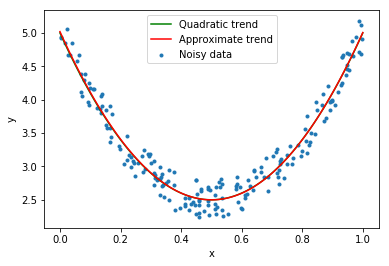

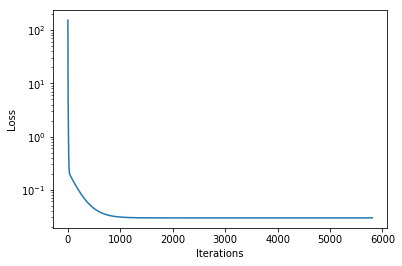

In [29]:
plt.scatter(X, Y, marker='.')
plt.plot(t, quadratic(t, A, B, C), 'g')
plt.plot(t, quadratic(t, a, b, c), 'r')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Quadratic trend", "Approximate trend", "Noisy data"])

plt.figure()

plt.semilogy(range(0,len(lossList)),lossList)
plt.xlabel("Iterations")
plt.ylabel("Loss")

## Sometimes, Gradients Won't Do

### The Cubic Polynomial

The blocks below implement the gradient descent for the cubic fitting problem, 
$$
y = ax^3+bx^2+cx+d,
$$
and proceed just as before. Run them and look at the results of the descent. Here are the functions:

In [30]:
# Functions

def cubic(x, a, b, c, d): return a*x**3 + b*x**2 + c*x + d
def loss(N, y, X, Y): return sum([(Y[k]-y[k])**2 for k in range(0, N)])/N
def aDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k])*X[k]**3 for k in range(0, N)])/N
def bDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k])*X[k]**2 for k in range(0, N)])/N
def cDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k])*X[k] for k in range(0, N)])/N
def dDerivative(N, y, X, Y): return -2*sum([(Y[k]-y[k]) for k in range(0, N)])/N

Here are the parameters:

In [31]:
# Parameters

A = 10
B = -15
C = 5
D = 2

N = 200
X = rand(N)

L = cubic(X, A, B, C, D)

sigma = 0.3
Y = L + (rand(N)*2-1)*sigma

a = (rand()*2-1)*10
b = (rand()*2-1)*10
c = (rand()*2-1)*10
d = (rand()*2-1)*10

Note that we have chosen initial guesses which are very close to the real values! Here is the plotting:

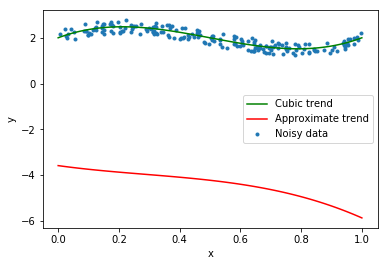

In [32]:
#Plotting

plt.scatter(X, Y, marker='.')
plt.plot(t, cubic(t, A, B, C, D), 'g')
plt.plot(t, cubic(t, a, b, c, d), 'r')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Cubic trend", "Approximate trend", "Noisy data"])

Finally, here is the main loop:

k = 0, descent failed. New step = 500.0
k = 1, descent failed. New step = 250.0
k = 2, descent failed. New step = 125.0
k = 3, descent failed. New step = 62.5
k = 4, descent failed. New step = 31.25
k = 5, descent failed. New step = 15.625
k = 6, descent failed. New step = 7.8125
k = 7, descent failed. New step = 3.90625
k = 8, descent failed. New step = 1.953125
k = 9, descent failed. New step = 0.9765625
k = 10, descent failed. New step = 0.48828125
k = 11. Loss = 22.693165045663033.
k = 12. Loss = 15.83483866885671.
k = 13. Loss = 11.454387152176146.
k = 14. Loss = 8.393591370685728.
k = 15. Loss = 6.196412777275038.
k = 16. Loss = 4.6070878838330085.
k = 17. Loss = 3.454819926376047.
k = 18. Loss = 2.6186580598461746.
k = 19. Loss = 2.0114908997911503.
k = 20. Loss = 1.5702876694382646.
k = 21. Loss = 1.2493842824803296.
k = 22. Loss = 1.0156871396835945.
k = 23. Loss = 0.8452104830505643.
k = 24. Loss = 0.7205693182798559.
k = 25. Loss = 0.6291627925058042.
k = 26. Loss = 0.561857

k = 271. Loss = 0.08403604993963995.
k = 272. Loss = 0.08382405236396177.
k = 273. Loss = 0.08361450983783414.
k = 274. Loss = 0.08340739305975609.
k = 275. Loss = 0.08320267307809383.
k = 276. Loss = 0.08300032128690343.
k = 277. Loss = 0.08280030942180326.
k = 278. Loss = 0.08260260955589542.
k = 279. Loss = 0.08240719409573631.
k = 280. Loss = 0.08221403577735485.
k = 281. Loss = 0.08202310766231861.
k = 282. Loss = 0.08183438313384667.
k = 283. Loss = 0.08164783589296919.
k = 284. Loss = 0.0814634399547324.
k = 285. Loss = 0.08128116964444944.
k = 286. Loss = 0.08110099959399512.
k = 287. Loss = 0.08092290473814635.
k = 288. Loss = 0.08074686031096444.
k = 289. Loss = 0.08057284184222241.
k = 290. Loss = 0.08040082515387315.
k = 291. Loss = 0.08023078635656176.
k = 292. Loss = 0.08006270184617767.
k = 293. Loss = 0.07989654830044908.
k = 294. Loss = 0.07973230267557754.
k = 295. Loss = 0.07956994220291314.
k = 296. Loss = 0.07940944438566877.
k = 297. Loss = 0.07925078699567455.
k 

k = 608. Loss = 0.06500082400792123.
k = 609. Loss = 0.06499110988061971.
k = 610. Loss = 0.06498143959984573.
k = 611. Loss = 0.0649718126539659.
k = 612. Loss = 0.06496222853745393.
k = 613. Loss = 0.06495268675081767.
k = 614. Loss = 0.06494318680052706.
k = 615. Loss = 0.06493372819894314.
k = 616. Loss = 0.06492431046424736.
k = 617. Loss = 0.06491493312037244.
k = 618. Loss = 0.06490559569693348.
k = 619. Loss = 0.06489629772916002.
k = 620. Loss = 0.06488703875782947.
k = 621. Loss = 0.0648778183292002.
k = 622. Loss = 0.06486863599494665.
k = 623. Loss = 0.06485949131209442.
k = 624. Loss = 0.0648503838429565.
k = 625. Loss = 0.06484131315506962.
k = 626. Loss = 0.06483227882113284.
k = 627. Loss = 0.06482328041894504.
k = 628. Loss = 0.06481431753134456.
k = 629. Loss = 0.06480538974614868.
k = 630. Loss = 0.06479649665609426.
k = 631. Loss = 0.06478763785877932.
k = 632. Loss = 0.06477881295660443.
k = 633. Loss = 0.06477002155671585.
k = 634. Loss = 0.06476126327094868.
k = 

k = 843. Loss = 0.06330591535513821.
k = 844. Loss = 0.06329980857342858.
k = 845. Loss = 0.0632937053104777.
k = 846. Loss = 0.0632876055357256.
k = 847. Loss = 0.06328150921897539.
k = 848. Loss = 0.06327541633038901.
k = 849. Loss = 0.06326932684048263.
k = 850. Loss = 0.06326324072012256.
k = 851. Loss = 0.06325715794052116.
k = 852. Loss = 0.06325107847323261.
k = 853. Loss = 0.06324500229014884.
k = 854. Loss = 0.06323892936349555.
k = 855. Loss = 0.06323285966582809.
k = 856. Loss = 0.06322679317002783.
k = 857. Loss = 0.06322072984929777.
k = 858. Loss = 0.06321466967715918.
k = 859. Loss = 0.06320861262744758.
k = 860. Loss = 0.06320255867430892.
k = 861. Loss = 0.06319650779219618.
k = 862. Loss = 0.06319045995586528.
k = 863. Loss = 0.06318441514037182.
k = 864. Loss = 0.06317837332106715.
k = 865. Loss = 0.06317233447359537.
k = 866. Loss = 0.06316629857388924.
k = 867. Loss = 0.06316026559816704.
k = 868. Loss = 0.0631542355229293.
k = 869. Loss = 0.06314820832495514.
k = 

k = 1062. Loss = 0.06202160215676342.
k = 1063. Loss = 0.062015902498915726.
k = 1064. Loss = 0.06201020396273549.
k = 1065. Loss = 0.06200450654587812.
k = 1066. Loss = 0.061998810246025354.
k = 1067. Loss = 0.06199311506088454.
k = 1068. Loss = 0.06198742098818884.
k = 1069. Loss = 0.06198172802569642.
k = 1070. Loss = 0.06197603617119055.
k = 1071. Loss = 0.06197034542247904.
k = 1072. Loss = 0.06196465577739424.
k = 1073. Loss = 0.06195896723379231.
k = 1074. Loss = 0.06195327978955341.
k = 1075. Loss = 0.06194759344258096.
k = 1076. Loss = 0.0619419081908019.
k = 1077. Loss = 0.061936224032165726.
k = 1078. Loss = 0.06193054096464492.
k = 1079. Loss = 0.06192485898623423.
k = 1080. Loss = 0.06191917809495056.
k = 1081. Loss = 0.061913498288832525.
k = 1082. Loss = 0.0619078195659405.
k = 1083. Loss = 0.061902141924356224.
k = 1084. Loss = 0.06189646536218245.
k = 1085. Loss = 0.06189078987754274.
k = 1086. Loss = 0.061885115468581206.
k = 1087. Loss = 0.061879442133462484.
k = 108

k = 1352. Loss = 0.06041061154642426.
k = 1353. Loss = 0.06040519248904561.
k = 1354. Loss = 0.06039977433171956.
k = 1355. Loss = 0.060394357074231034.
k = 1356. Loss = 0.06038894071636619.
k = 1357. Loss = 0.06038352525791181.
k = 1358. Loss = 0.06037811069865544.
k = 1359. Loss = 0.06037269703838542.
k = 1360. Loss = 0.06036728427689095.
k = 1361. Loss = 0.0603618724139621.
k = 1362. Loss = 0.06035646144938939.
k = 1363. Loss = 0.060351051382964614.
k = 1364. Loss = 0.06034564221447981.
k = 1365. Loss = 0.060340233943728.
k = 1366. Loss = 0.060334826570502875.
k = 1367. Loss = 0.06032942009459903.
k = 1368. Loss = 0.060324014515811514.
k = 1369. Loss = 0.060318609833936276.
k = 1370. Loss = 0.060313206048769864.
k = 1371. Loss = 0.060307803160109676.
k = 1372. Loss = 0.06030240116775354.
k = 1373. Loss = 0.06029700007150012.
k = 1374. Loss = 0.06029159987114883.
k = 1375. Loss = 0.06028620056649962.
k = 1376. Loss = 0.06028080215735306.
k = 1377. Loss = 0.06027540464351049.
k = 1378

k = 1655. Loss = 0.058808994664927346.
k = 1656. Loss = 0.05880384043236684.
k = 1657. Loss = 0.05879868705073939.
k = 1658. Loss = 0.05879353451990262.
k = 1659. Loss = 0.05878838283971449.
k = 1660. Loss = 0.05878323201003287.
k = 1661. Loss = 0.05877808203071569.
k = 1662. Loss = 0.05877293290162082.
k = 1663. Loss = 0.058767784622606435.
k = 1664. Loss = 0.05876263719353049.
k = 1665. Loss = 0.05875749061425117.
k = 1666. Loss = 0.05875234488462653.
k = 1667. Loss = 0.05874720000451487.
k = 1668. Loss = 0.058742055973774285.
k = 1669. Loss = 0.058736912792263174.
k = 1670. Loss = 0.058731770459839766.
k = 1671. Loss = 0.058726628976362466.
k = 1672. Loss = 0.05872148834168964.
k = 1673. Loss = 0.05871634855567975.
k = 1674. Loss = 0.05871120961819125.
k = 1675. Loss = 0.058706071529082714.
k = 1676. Loss = 0.05870093428821261.
k = 1677. Loss = 0.05869579789543962.
k = 1678. Loss = 0.05869066235062232.
k = 1679. Loss = 0.0586855276536194.
k = 1680. Loss = 0.05868039380428969.
k = 16

k = 1957. Loss = 0.05729045770175019.
k = 1958. Loss = 0.0572855541394902.
k = 1959. Loss = 0.057280651386644156.
k = 1960. Loss = 0.05727574944307839.
k = 1961. Loss = 0.05727084830865941.
k = 1962. Loss = 0.05726594798325348.
k = 1963. Loss = 0.057261048466727076.
k = 1964. Loss = 0.05725614975894648.
k = 1965. Loss = 0.05725125185977836.
k = 1966. Loss = 0.05724635476908916.
k = 1967. Loss = 0.05724145848674527.
k = 1968. Loss = 0.05723656301261326.
k = 1969. Loss = 0.057231668346559704.
k = 1970. Loss = 0.05722677448845121.
k = 1971. Loss = 0.05722188143815435.
k = 1972. Loss = 0.05721698919553572.
k = 1973. Loss = 0.057212097760462016.
k = 1974. Loss = 0.05720720713279975.
k = 1975. Loss = 0.05720231731241579.
k = 1976. Loss = 0.05719742829917674.
k = 1977. Loss = 0.057192540092949384.
k = 1978. Loss = 0.057187652693600446.
k = 1979. Loss = 0.0571827661009967.
k = 1980. Loss = 0.057177880315004946.
k = 1981. Loss = 0.057172995335492034.
k = 1982. Loss = 0.05716811116232475.
k = 19

k = 2258. Loss = 0.05585043649876462.
k = 2259. Loss = 0.05584577063497379.
k = 2260. Loss = 0.055841105541357364.
k = 2261. Loss = 0.05583644121778804.
k = 2262. Loss = 0.05583177766413888.
k = 2263. Loss = 0.05582711488028266.
k = 2264. Loss = 0.0558224528660924.
k = 2265. Loss = 0.05581779162144099.
k = 2266. Loss = 0.055813131146201435.
k = 2267. Loss = 0.05580847144024674.
k = 2268. Loss = 0.055803812503449964.
k = 2269. Loss = 0.055799154335684.
k = 2270. Loss = 0.05579449693682204.
k = 2271. Loss = 0.05578984030673715.
k = 2272. Loss = 0.05578518444530236.
k = 2273. Loss = 0.05578052935239082.
k = 2274. Loss = 0.05577587502787575.
k = 2275. Loss = 0.05577122147163023.
k = 2276. Loss = 0.05576656868352743.
k = 2277. Loss = 0.05576191666344057.
k = 2278. Loss = 0.055757265411242984.
k = 2279. Loss = 0.05575261492680776.
k = 2280. Loss = 0.05574796521000826.
k = 2281. Loss = 0.05574331626071767.
k = 2282. Loss = 0.05573866807880946.
k = 2283. Loss = 0.055734020664156884.
k = 2284. 

k = 2481. Loss = 0.054828783269863256.
k = 2482. Loss = 0.054824286046018196.
k = 2483. Loss = 0.05481978956451077.
k = 2484. Loss = 0.054815293825218304.
k = 2485. Loss = 0.054810798828018384.
k = 2486. Loss = 0.054806304572788456.
k = 2487. Loss = 0.05480181105940609.
k = 2488. Loss = 0.05479731828774877.
k = 2489. Loss = 0.05479282625769409.
k = 2490. Loss = 0.05478833496911965.
k = 2491. Loss = 0.05478384442190306.
k = 2492. Loss = 0.05477935461592194.
k = 2493. Loss = 0.05477486555105394.
k = 2494. Loss = 0.054770377227176724.
k = 2495. Loss = 0.05476588964416798.
k = 2496. Loss = 0.054761402801905404.
k = 2497. Loss = 0.054756916700266764.
k = 2498. Loss = 0.05475243133912974.
k = 2499. Loss = 0.054747946718372145.
k = 2500. Loss = 0.0547434628378717.
k = 2501. Loss = 0.05473897969750643.
k = 2502. Loss = 0.054734497297153926.
k = 2503. Loss = 0.05473001563669209.
k = 2504. Loss = 0.05472553471599885.
k = 2505. Loss = 0.0547210545349521.
k = 2506. Loss = 0.05471657509342967.
k = 

k = 2706. Loss = 0.053835387366853525.
k = 2707. Loss = 0.05383105411863056.
k = 2708. Loss = 0.0538267215856784.
k = 2709. Loss = 0.05382238976787894.
k = 2710. Loss = 0.05381805866511416.
k = 2711. Loss = 0.05381372827726612.
k = 2712. Loss = 0.0538093986042166.
k = 2713. Loss = 0.0538050696458478.
k = 2714. Loss = 0.05380074140204164.
k = 2715. Loss = 0.0537964138726802.
k = 2716. Loss = 0.05379208705764562.
k = 2717. Loss = 0.05378776095681984.
k = 2718. Loss = 0.05378343557008515.
k = 2719. Loss = 0.05377911089732356.
k = 2720. Loss = 0.05377478693841721.
k = 2721. Loss = 0.05377046369324837.
k = 2722. Loss = 0.05376614116169906.
k = 2723. Loss = 0.053761819343651644.
k = 2724. Loss = 0.053757498238988274.
k = 2725. Loss = 0.053753177847591226.
k = 2726. Loss = 0.05374885816934271.
k = 2727. Loss = 0.05374453920412507.
k = 2728. Loss = 0.05374022095182062.
k = 2729. Loss = 0.053735903412311554.
k = 2730. Loss = 0.053731586585480405.
k = 2731. Loss = 0.05372727047120933.
k = 2732. 

k = 3028. Loss = 0.05247640496822003.
k = 3029. Loss = 0.05247229604142101.
k = 3030. Loss = 0.05246818779286493.
k = 3031. Loss = 0.05246408022243995.
k = 3032. Loss = 0.052459973330034125.
k = 3033. Loss = 0.05245586711553543.
k = 3034. Loss = 0.052451761578832065.
k = 3035. Loss = 0.05244765671981209.
k = 3036. Loss = 0.05244355253836369.
k = 3037. Loss = 0.052439449034375016.
k = 3038. Loss = 0.05243534620773427.
k = 3039. Loss = 0.05243124405832951.
k = 3040. Loss = 0.0524271425860491.
k = 3041. Loss = 0.05242304179078122.
k = 3042. Loss = 0.05241894167241408.
k = 3043. Loss = 0.05241484223083599.
k = 3044. Loss = 0.05241074346593521.
k = 3045. Loss = 0.05240664537760008.
k = 3046. Loss = 0.05240254796571893.
k = 3047. Loss = 0.05239845123017996.
k = 3048. Loss = 0.05239435517087175.
k = 3049. Loss = 0.052390259787682546.
k = 3050. Loss = 0.05238616508050073.
k = 3051. Loss = 0.05238207104921479.
k = 3052. Loss = 0.05237797769371312.
k = 3053. Loss = 0.05237388501388411.
k = 3054.

k = 3270. Loss = 0.05150156430617632.
k = 3271. Loss = 0.05149761629216434.
k = 3272. Loss = 0.05149366892983418.
k = 3273. Loss = 0.05148972221907834.
k = 3274. Loss = 0.051485776159789116.
k = 3275. Loss = 0.05148183075185909.
k = 3276. Loss = 0.051477885995180675.
k = 3277. Loss = 0.05147394188964645.
k = 3278. Loss = 0.05146999843514886.
k = 3279. Loss = 0.05146605563158043.
k = 3280. Loss = 0.05146211347883384.
k = 3281. Loss = 0.05145817197680153.
k = 3282. Loss = 0.051454231125376164.
k = 3283. Loss = 0.05145029092445027.
k = 3284. Loss = 0.05144635137391657.
k = 3285. Loss = 0.05144241247366765.
k = 3286. Loss = 0.05143847422359618.
k = 3287. Loss = 0.05143453662359488.
k = 3288. Loss = 0.05143059967355637.
k = 3289. Loss = 0.0514266633733734.
k = 3290. Loss = 0.05142272772293865.
k = 3291. Loss = 0.05141879272214493.
k = 3292. Loss = 0.05141485837088509.
k = 3293. Loss = 0.05141092466905172.
k = 3294. Loss = 0.051406991616537764.
k = 3295. Loss = 0.05140305921323598.
k = 3296.

k = 3545. Loss = 0.05044004787145471.
k = 3546. Loss = 0.050436275077429656.
k = 3547. Loss = 0.050432502906163565.
k = 3548. Loss = 0.0504287313575537.
k = 3549. Loss = 0.05042496043149733.
k = 3550. Loss = 0.05042119012789158.
k = 3551. Loss = 0.050417420446633665.
k = 3552. Loss = 0.050413651387621085.
k = 3553. Loss = 0.05040988295075094.
k = 3554. Loss = 0.050406115135920505.
k = 3555. Loss = 0.05040234794302722.
k = 3556. Loss = 0.050398581371968475.
k = 3557. Loss = 0.05039481542264146.
k = 3558. Loss = 0.050391050094943636.
k = 3559. Loss = 0.05038728538877238.
k = 3560. Loss = 0.05038352130402509.
k = 3561. Loss = 0.05037975784059927.
k = 3562. Loss = 0.05037599499839222.
k = 3563. Loss = 0.05037223277730155.
k = 3564. Loss = 0.0503684711772246.
k = 3565. Loss = 0.05036471019805891.
k = 3566. Loss = 0.05036094983970203.
k = 3567. Loss = 0.05035719010205138.
k = 3568. Loss = 0.05035343098500466.
k = 3569. Loss = 0.05034967248845931.
k = 3570. Loss = 0.05034591461231295.
k = 357

k = 3777. Loss = 0.049581237908347314.
k = 3778. Loss = 0.04957760687441711.
k = 3779. Loss = 0.049573976439846186.
k = 3780. Loss = 0.04957034660453557.
k = 3781. Loss = 0.04956671736838639.
k = 3782. Loss = 0.049563088731299755.
k = 3783. Loss = 0.049559460693176766.
k = 3784. Loss = 0.04955583325391848.
k = 3785. Loss = 0.049552206413426086.
k = 3786. Loss = 0.049548580171600874.
k = 3787. Loss = 0.04954495452834389.
k = 3788. Loss = 0.04954132948355631.
k = 3789. Loss = 0.04953770503713944.
k = 3790. Loss = 0.04953408118899445.
k = 3791. Loss = 0.04953045793902264.
k = 3792. Loss = 0.04952683528712524.
k = 3793. Loss = 0.049523213233203495.
k = 3794. Loss = 0.049519591777158735.
k = 3795. Loss = 0.049515970918892246.
k = 3796. Loss = 0.04951235065830535.
k = 3797. Loss = 0.049508730995299545.
k = 3798. Loss = 0.04950511192977598.
k = 3799. Loss = 0.049501493461636105.
k = 3800. Loss = 0.04949787559078133.
k = 3801. Loss = 0.04949425831711308.
k = 3802. Loss = 0.0494906416405327.
k 

k = 4040. Loss = 0.04864663231951245.
k = 4041. Loss = 0.048643155556937545.
k = 4042. Loss = 0.0486396793682569.
k = 4043. Loss = 0.04863620375337602.
k = 4044. Loss = 0.048632728712199966.
k = 4045. Loss = 0.048629254244634164.
k = 4046. Loss = 0.04862578035058381.
k = 4047. Loss = 0.04862230702995442.
k = 4048. Loss = 0.04861883428265117.
k = 4049. Loss = 0.04861536210857955.
k = 4050. Loss = 0.04861189050764488.
k = 4051. Loss = 0.04860841947975257.
k = 4052. Loss = 0.04860494902480797.
k = 4053. Loss = 0.04860147914271659.
k = 4054. Loss = 0.0485980098333838.
k = 4055. Loss = 0.04859454109671511.
k = 4056. Loss = 0.04859107293261599.
k = 4057. Loss = 0.04858760534099187.
k = 4058. Loss = 0.04858413832174837.
k = 4059. Loss = 0.04858067187479086.
k = 4060. Loss = 0.048577206000025.
k = 4061. Loss = 0.048573740697356274.
k = 4062. Loss = 0.0485702759666903.
k = 4063. Loss = 0.048566811807932604.
k = 4064. Loss = 0.0485633482209888.
k = 4065. Loss = 0.04855988520576452.
k = 4066. Los

k = 4276. Loss = 0.047841827501535386.
k = 4277. Loss = 0.0478384835846565.
k = 4278. Loss = 0.0478351402197437.
k = 4279. Loss = 0.04783179740670593.
k = 4280. Loss = 0.047828455145452045.
k = 4281. Loss = 0.047825113435890874.
k = 4282. Loss = 0.0478217722779315.
k = 4283. Loss = 0.0478184316714828.
k = 4284. Loss = 0.047815091616453795.
k = 4285. Loss = 0.04781175211275333.
k = 4286. Loss = 0.047808413160290525.
k = 4287. Loss = 0.04780507475897432.
k = 4288. Loss = 0.04780173690871381.
k = 4289. Loss = 0.04779839960941797.
k = 4290. Loss = 0.04779506286099588.
k = 4291. Loss = 0.04779172666335664.
k = 4292. Loss = 0.04778839101640932.
k = 4293. Loss = 0.04778505592006296.
k = 4294. Loss = 0.04778172137422671.
k = 4295. Loss = 0.04777838737880976.
k = 4296. Loss = 0.04777505393372119.
k = 4297. Loss = 0.04777172103887008.
k = 4298. Loss = 0.047768388694165796.
k = 4299. Loss = 0.047765056899517405.
k = 4300. Loss = 0.04776172565483414.
k = 4301. Loss = 0.047758394960025236.
k = 4302

k = 4644. Loss = 0.046647799819565.
k = 4645. Loss = 0.046644652995739.
k = 4646. Loss = 0.04664150669134582.
k = 4647. Loss = 0.04663836090629961.
k = 4648. Loss = 0.04663521564051474.
k = 4649. Loss = 0.0466320708939055.
k = 4650. Loss = 0.04662892666638609.
k = 4651. Loss = 0.046625782957870954.
k = 4652. Loss = 0.04662263976827436.
k = 4653. Loss = 0.04661949709751067.
k = 4654. Loss = 0.046616354945494196.
k = 4655. Loss = 0.046613213312139336.
k = 4656. Loss = 0.046610072197360485.
k = 4657. Loss = 0.04660693160107211.
k = 4658. Loss = 0.04660379152318852.
k = 4659. Loss = 0.04660065196362417.
k = 4660. Loss = 0.04659751292229349.
k = 4661. Loss = 0.04659437439911099.
k = 4662. Loss = 0.0465912363939911.
k = 4663. Loss = 0.04658809890684837.
k = 4664. Loss = 0.04658496193759723.
k = 4665. Loss = 0.0465818254861522.
k = 4666. Loss = 0.04657868955242781.
k = 4667. Loss = 0.04657555413633862.
k = 4668. Loss = 0.04657241923779918.
k = 4669. Loss = 0.04656928485672407.
k = 4670. Loss 

k = 4867. Loss = 0.04595876068969045.
k = 4868. Loss = 0.04595572760261252.
k = 4869. Loss = 0.04595269501619334.
k = 4870. Loss = 0.04594966293035028.
k = 4871. Loss = 0.045946631345000696.
k = 4872. Loss = 0.04594360026006194.
k = 4873. Loss = 0.04594056967545139.
k = 4874. Loss = 0.04593753959108654.
k = 4875. Loss = 0.045934510006884796.
k = 4876. Loss = 0.0459314809227636.
k = 4877. Loss = 0.045928452338640374.
k = 4878. Loss = 0.045925424254432606.
k = 4879. Loss = 0.045922396670057763.
k = 4880. Loss = 0.045919369585433356.
k = 4881. Loss = 0.04591634300047689.
k = 4882. Loss = 0.04591331691510587.
k = 4883. Loss = 0.045910291329237844.
k = 4884. Loss = 0.04590726624279038.
k = 4885. Loss = 0.04590424165568102.
k = 4886. Loss = 0.04590121756782732.
k = 4887. Loss = 0.045898193979146955.
k = 4888. Loss = 0.045895170889557434.
k = 4889. Loss = 0.04589214829897637.
k = 4890. Loss = 0.04588912620732147.
k = 4891. Loss = 0.04588610461451032.
k = 4892. Loss = 0.04588308352046066.
k = 

k = 5143. Loss = 0.045140345409463455.
k = 5144. Loss = 0.04513744741470251.
k = 5145. Loss = 0.045134549898301214.
k = 5146. Loss = 0.04513165286018056.
k = 5147. Loss = 0.04512875630026161.
k = 5148. Loss = 0.04512586021846549.
k = 5149. Loss = 0.04512296461471322.
k = 5150. Loss = 0.04512006948892589.
k = 5151. Loss = 0.045117174841024614.
k = 5152. Loss = 0.04511428067093053.
k = 5153. Loss = 0.045111386978564705.
k = 5154. Loss = 0.045108493763848394.
k = 5155. Loss = 0.04510560102670261.
k = 5156. Loss = 0.045102708767048624.
k = 5157. Loss = 0.045099816984807625.
k = 5158. Loss = 0.04509692567990076.
k = 5159. Loss = 0.04509403485224928.
k = 5160. Loss = 0.04509114450177432.
k = 5161. Loss = 0.04508825462839722.
k = 5162. Loss = 0.0450853652320392.
k = 5163. Loss = 0.045082476312621494.
k = 5164. Loss = 0.045079587870065344.
k = 5165. Loss = 0.04507669990429208.
k = 5166. Loss = 0.04507381241522302.
k = 5167. Loss = 0.04507092540277953.
k = 5168. Loss = 0.045068038866882744.
k =

k = 5542. Loss = 0.04402121144322699.
k = 5543. Loss = 0.044018498179132955.
k = 5544. Loss = 0.04401578536290585.
k = 5545. Loss = 0.04401307299447172.
k = 5546. Loss = 0.04401036107375667.
k = 5547. Loss = 0.044007649600686795.
k = 5548. Loss = 0.044004938575188224.
k = 5549. Loss = 0.044002227997187095.
k = 5550. Loss = 0.04399951786660945.
k = 5551. Loss = 0.0439968081833815.
k = 5552. Loss = 0.043994098947429394.
k = 5553. Loss = 0.043991390158679325.
k = 5554. Loss = 0.043988681817057416.
k = 5555. Loss = 0.043985973922489936.
k = 5556. Loss = 0.04398326647490304.
k = 5557. Loss = 0.043980559474222976.
k = 5558. Loss = 0.04397785292037592.
k = 5559. Loss = 0.04397514681328819.
k = 5560. Loss = 0.04397244115288602.
k = 5561. Loss = 0.04396973593909559.
k = 5562. Loss = 0.04396703117184333.
k = 5563. Loss = 0.043964326851055426.
k = 5564. Loss = 0.04396162297665821.
k = 5565. Loss = 0.04395891954857801.
k = 5566. Loss = 0.04395621656674113.
k = 5567. Loss = 0.04395351403107394.
k =

k = 5949. Loss = 0.04295310516117144.
k = 5950. Loss = 0.04295056820482228.
k = 5951. Loss = 0.04294803166723767.
k = 5952. Loss = 0.0429454955483485.
k = 5953. Loss = 0.042942959848085625.
k = 5954. Loss = 0.04294042456637999.
k = 5955. Loss = 0.042937889703162486.
k = 5956. Loss = 0.04293535525836404.
k = 5957. Loss = 0.04293282123191559.
k = 5958. Loss = 0.04293028762374801.
k = 5959. Loss = 0.042927754433792355.
k = 5960. Loss = 0.04292522166197955.
k = 5961. Loss = 0.042922689308240544.
k = 5962. Loss = 0.042920157372506436.
k = 5963. Loss = 0.04291762585470808.
k = 5964. Loss = 0.04291509475477663.
k = 5965. Loss = 0.042912564072642975.
k = 5966. Loss = 0.04291003380823828.
k = 5967. Loss = 0.04290750396149351.
k = 5968. Loss = 0.042904974532339706.
k = 5969. Loss = 0.042902445520708.
k = 5970. Loss = 0.042899916926529474.
k = 5971. Loss = 0.04289738874973516.
k = 5972. Loss = 0.04289486099025623.
k = 5973. Loss = 0.04289233364802374.
k = 5974. Loss = 0.042889806722968854.
k = 59

k = 6595. Loss = 0.04139846360370202.
k = 6596. Loss = 0.041396183265398935.
k = 6597. Loss = 0.041393903303501504.
k = 6598. Loss = 0.04139162371794769.
k = 6599. Loss = 0.04138934450867533.
k = 6600. Loss = 0.0413870656756223.
k = 6601. Loss = 0.0413847872187266.
k = 6602. Loss = 0.041382509137925946.
k = 6603. Loss = 0.04138023143315841.
k = 6604. Loss = 0.041377954104361854.
k = 6605. Loss = 0.041375677151474256.
k = 6606. Loss = 0.04137340057443355.
k = 6607. Loss = 0.04137112437317771.
k = 6608. Loss = 0.04136884854764471.
k = 6609. Loss = 0.0413665730977725.
k = 6610. Loss = 0.041364298023499085.
k = 6611. Loss = 0.041362023324762465.
k = 6612. Loss = 0.041359749001500655.
k = 6613. Loss = 0.04135747505365171.
k = 6614. Loss = 0.041355201481153576.
k = 6615. Loss = 0.041352928283944414.
k = 6616. Loss = 0.04135065546196214.
k = 6617. Loss = 0.04134838301514493.
k = 6618. Loss = 0.04134611094343083.
k = 6619. Loss = 0.04134383924675788.
k = 6620. Loss = 0.04134156792506423.
k = 6

k = 6911. Loss = 0.04069629088985278.
k = 6912. Loss = 0.04069412645620241.
k = 6913. Loss = 0.04069196237982582.
k = 6914. Loss = 0.04068979866066412.
k = 6915. Loss = 0.04068763529865827.
k = 6916. Loss = 0.040685472293749386.
k = 6917. Loss = 0.04068330964587849.
k = 6918. Loss = 0.040681147354986645.
k = 6919. Loss = 0.040678985421014904.
k = 6920. Loss = 0.040676823843904426.
k = 6921. Loss = 0.04067466262359619.
k = 6922. Loss = 0.040672501760031385.
k = 6923. Loss = 0.04067034125315114.
k = 6924. Loss = 0.040668181102896515.
k = 6925. Loss = 0.040666021309208676.
k = 6926. Loss = 0.04066386187202876.
k = 6927. Loss = 0.040661702791297945.
k = 6928. Loss = 0.04065954406695733.
k = 6929. Loss = 0.040657385698948154.
k = 6930. Loss = 0.04065522768721155.
k = 6931. Loss = 0.040653070031688755.
k = 6932. Loss = 0.04065091273232093.
k = 6933. Loss = 0.04064875578904932.
k = 6934. Loss = 0.04064659920181515.
k = 6935. Loss = 0.04064444297055959.
k = 6936. Loss = 0.040642287095223925.
k

k = 7139. Loss = 0.040211931641460946.
k = 7140. Loss = 0.04020984715892422.
k = 7141. Loss = 0.04020776302046418.
k = 7142. Loss = 0.04020567922602398.
k = 7143. Loss = 0.0402035957755468.
k = 7144. Loss = 0.0402015126689759.
k = 7145. Loss = 0.04019942990625454.
k = 7146. Loss = 0.04019734748732591.
k = 7147. Loss = 0.04019526541213328.
k = 7148. Loss = 0.0401931836806199.
k = 7149. Loss = 0.04019110229272911.
k = 7150. Loss = 0.040189021248404073.
k = 7151. Loss = 0.040186940547588174.
k = 7152. Loss = 0.04018486019022469.
k = 7153. Loss = 0.04018278017625688.
k = 7154. Loss = 0.04018070050562814.
k = 7155. Loss = 0.040178621178281713.
k = 7156. Loss = 0.040176542194160995.
k = 7157. Loss = 0.04017446355320934.
k = 7158. Loss = 0.04017238525537005.
k = 7159. Loss = 0.04017030730058649.
k = 7160. Loss = 0.040168229688802064.
k = 7161. Loss = 0.040166152419960174.
k = 7162. Loss = 0.04016407549400415.
k = 7163. Loss = 0.040161998910877454.
k = 7164. Loss = 0.040159922670523464.
k = 71

k = 7639. Loss = 0.03921146152102007.
k = 7640. Loss = 0.039209542181815785.
k = 7641. Loss = 0.03920762315942856.
k = 7642. Loss = 0.039205704453806195.
k = 7643. Loss = 0.03920378606489639.
k = 7644. Loss = 0.03920186799264689.
k = 7645. Loss = 0.03919995023700534.
k = 7646. Loss = 0.039198032797919516.
k = 7647. Loss = 0.03919611567533723.
k = 7648. Loss = 0.03919419886920614.
k = 7649. Loss = 0.039192282379474044.
k = 7650. Loss = 0.03919036620608876.
k = 7651. Loss = 0.039188450348998045.
k = 7652. Loss = 0.03918653480814967.
k = 7653. Loss = 0.039184619583491447.
k = 7654. Loss = 0.03918270467497116.
k = 7655. Loss = 0.03918079008253667.
k = 7656. Loss = 0.03917887580613578.
k = 7657. Loss = 0.03917696184571633.
k = 7658. Loss = 0.03917504820122614.
k = 7659. Loss = 0.0391731348726131.
k = 7660. Loss = 0.039171221859825064.
k = 7661. Loss = 0.03916930916280983.
k = 7662. Loss = 0.03916739678151538.
k = 7663. Loss = 0.039165484715889515.
k = 7664. Loss = 0.03916357296588015.
k = 7

k = 7905. Loss = 0.038711923059545496.
k = 7906. Loss = 0.03871008617702278.
k = 7907. Loss = 0.03870824959770645.
k = 7908. Loss = 0.03870641332154639.
k = 7909. Loss = 0.03870457734849263.
k = 7910. Loss = 0.038702741678495065.
k = 7911. Loss = 0.03870090631150372.
k = 7912. Loss = 0.03869907124746859.
k = 7913. Loss = 0.03869723648633964.
k = 7914. Loss = 0.03869540202806687.
k = 7915. Loss = 0.038693567872600275.
k = 7916. Loss = 0.03869173401988994.
k = 7917. Loss = 0.03868990046988585.
k = 7918. Loss = 0.03868806722253798.
k = 7919. Loss = 0.03868623427779647.
k = 7920. Loss = 0.03868440163561128.
k = 7921. Loss = 0.03868256929593253.
k = 7922. Loss = 0.03868073725871031.
k = 7923. Loss = 0.03867890552389463.
k = 7924. Loss = 0.03867707409143563.
k = 7925. Loss = 0.03867524296128328.
k = 7926. Loss = 0.03867341213338782.
k = 7927. Loss = 0.038671581607699325.
k = 7928. Loss = 0.03866975138416785.
k = 7929. Loss = 0.03866792146274361.
k = 7930. Loss = 0.03866609184337664.
k = 7931

k = 8138. Loss = 0.0382920213146309.
k = 8139. Loss = 0.03829025374349691.
k = 8140. Loss = 0.03828848646412832.
k = 8141. Loss = 0.03828671947647702.
k = 8142. Loss = 0.03828495278049484.
k = 8143. Loss = 0.0382831863761336.
k = 8144. Loss = 0.038281420263345176.
k = 8145. Loss = 0.0382796544420815.
k = 8146. Loss = 0.03827788891229434.
k = 8147. Loss = 0.03827612367393571.
k = 8148. Loss = 0.03827435872695739.
k = 8149. Loss = 0.038272594071311346.
k = 8150. Loss = 0.038270829706949484.
k = 8151. Loss = 0.03826906563382372.
k = 8152. Loss = 0.038267301851886.
k = 8153. Loss = 0.03826553836108816.
k = 8154. Loss = 0.03826377516138228.
k = 8155. Loss = 0.03826201225272023.
k = 8156. Loss = 0.03826024963505404.
k = 8157. Loss = 0.03825848730833554.
k = 8158. Loss = 0.038256725272516855.
k = 8159. Loss = 0.038254963527549875.
k = 8160. Loss = 0.03825320207338663.
k = 8161. Loss = 0.0382514409099791.
k = 8162. Loss = 0.038249680037279285.
k = 8163. Loss = 0.0382479194552392.
k = 8164. Los

k = 8529. Loss = 0.0376226780476928.
k = 8530. Loss = 0.03762102096219489.
k = 8531. Loss = 0.03761936415022496.
k = 8532. Loss = 0.037617707611737924.
k = 8533. Loss = 0.037616051346688606.
k = 8534. Loss = 0.03761439535503193.
k = 8535. Loss = 0.03761273963672272.
k = 8536. Loss = 0.03761108419171583.
k = 8537. Loss = 0.037609429019966216.
k = 8538. Loss = 0.037607774121428725.
k = 8539. Loss = 0.037606119496058264.
k = 8540. Loss = 0.03760446514380977.
k = 8541. Loss = 0.037602811064638114.
k = 8542. Loss = 0.03760115725849829.
k = 8543. Loss = 0.037599503725345165.
k = 8544. Loss = 0.037597850465133656.
k = 8545. Loss = 0.03759619747781882.
k = 8546. Loss = 0.0375945447633555.
k = 8547. Loss = 0.03759289232169873.
k = 8548. Loss = 0.037591240152803435.
k = 8549. Loss = 0.0375895882566246.
k = 8550. Loss = 0.03758793663311722.
k = 8551. Loss = 0.037586285282236294.
k = 8552. Loss = 0.03758463420393682.
k = 8553. Loss = 0.037582983398173786.
k = 8554. Loss = 0.0375813328649022.
k = 8

k = 8979. Loss = 0.036903953972164165.
k = 8980. Loss = 0.03690241552338159.
k = 8981. Loss = 0.036900877328544114.
k = 8982. Loss = 0.03689933938760999.
k = 8983. Loss = 0.03689780170053713.
k = 8984. Loss = 0.03689626426728377.
k = 8985. Loss = 0.03689472708780792.
k = 8986. Loss = 0.03689319016206773.
k = 8987. Loss = 0.03689165349002132.
k = 8988. Loss = 0.03689011707162681.
k = 8989. Loss = 0.036888580906842335.
k = 8990. Loss = 0.036887044995625985.
k = 8991. Loss = 0.03688550933793599.
k = 8992. Loss = 0.03688397393373045.
k = 8993. Loss = 0.03688243878296748.
k = 8994. Loss = 0.036880903885605325.
k = 8995. Loss = 0.036879369241602136.
k = 8996. Loss = 0.03687783485091609.
k = 8997. Loss = 0.036876300713505346.
k = 8998. Loss = 0.0368747668293281.
k = 8999. Loss = 0.03687323319834258.
k = 9000. Loss = 0.036871699820507.
k = 9001. Loss = 0.03687016669577955.
k = 9002. Loss = 0.03686863382411842.
k = 9003. Loss = 0.03686710120548191.
k = 9004. Loss = 0.036865568839828215.
k = 900

k = 9616. Loss = 0.03597365153134842.
k = 9617. Loss = 0.03597226664361882.
k = 9618. Loss = 0.03597088198448675.
k = 9619. Loss = 0.035969497553914424.
k = 9620. Loss = 0.03596811335186415.
k = 9621. Loss = 0.03596672937829819.
k = 9622. Loss = 0.03596534563317887.
k = 9623. Loss = 0.03596396211646845.
k = 9624. Loss = 0.03596257882812917.
k = 9625. Loss = 0.03596119576812345.
k = 9626. Loss = 0.03595981293641352.
k = 9627. Loss = 0.03595843033296171.
k = 9628. Loss = 0.03595704795773034.
k = 9629. Loss = 0.03595566581068181.
k = 9630. Loss = 0.03595428389177831.
k = 9631. Loss = 0.035952902200982316.
k = 9632. Loss = 0.03595152073825612.
k = 9633. Loss = 0.03595013950356205.
k = 9634. Loss = 0.03594875849686254.
k = 9635. Loss = 0.03594737771811993.
k = 9636. Loss = 0.03594599716729648.
k = 9637. Loss = 0.03594461684435475.
k = 9638. Loss = 0.03594323674925701.
k = 9639. Loss = 0.03594185688196567.
k = 9640. Loss = 0.03594047724244311.
k = 9641. Loss = 0.035939097830651766.
k = 9642.

Text(0, 0.5, 'Loss')

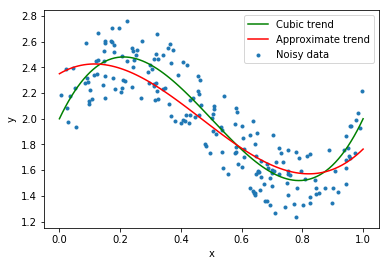

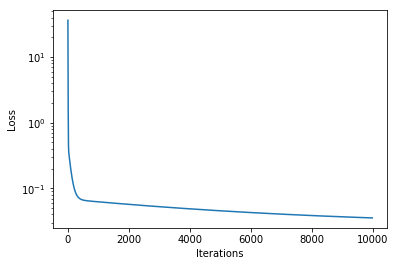

In [33]:
a = (rand()*2-1)*10
b = (rand()*2-1)*10
c = (rand()*2-1)*10
d = (rand()*2-1)*10

y = cubic(X, a, b, c, d)

s = 1000
tol = 1.0e-8

lossCurrent = loss(N, y, X, Y)
lossList = [lossCurrent]

for k in range(0, 10000):
    aDer = aDerivative(N, y, X, Y)
    bDer = bDerivative(N, y, X, Y)
    cDer = cDerivative(N, y, X, Y)
    dDer = dDerivative(N, y, X, Y)
    
    aDerAbs = abs(aDer)
    bDerAbs = abs(bDer)
    cDerAbs = abs(cDer)
    dDerAbs = abs(dDer)
    
    aNew = a - s*aDer
    bNew = b - s*bDer
    cNew = c - s*cDer
    dNew = d - s*dDer
    
    yNew = cubic(X, aNew, bNew, cNew, dNew)

    lossNew = loss(N, yNew, X, Y)

    if lossNew > lossCurrent:
        s = s/2
        print(f"k = {k}, descent failed. New step = {s}")
    else:
        a = aNew
        b = bNew
        c = cNew
        d = dNew
        y = yNew
        
        lossCurrent = lossNew
        lossList.append(lossCurrent)
        print(f"k = {k}. Loss = {lossNew}.")
    
    if aDerAbs<tol and bDerAbs<tol and cDerAbs<tol and dDerAbs<tol:
        break

print(f"\n True values: A = {A}, B = {B}, C = {C}, D = {D}.")
print(f"\n Approximate values: a = {a}, b = {b}, c = {c}, d = {d}.")

plt.scatter(X, Y, marker='.')
plt.plot(t, cubic(t, A, B, C, D), 'g')
plt.plot(t, cubic(t, a, b, c, d), 'r')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Cubic trend", "Approximate trend", "Noisy data"])

plt.figure()
plt.semilogy(range(0,len(lossList)),lossList)
plt.xlabel("Iterations")
plt.ylabel("Loss")

What went wrong? Well... nothing. The algorithm has run for 10000 iterations and simply has not converged yet. The choice of parameters have improved, the guess is *close* to the original trend, the loss has decreased over time, but the algorithm simply isn't done yet because the optimisation in four parameters is slow. **Gradient descent is slow**.

### The Barzilai-Borwein Update

One of the reasons the previous algorithm was very slow is that the step $s_n$ was not set in a very thoughtful way; once it decreased, it was not allowed to increase again. We will use this type of gradient descent to implement a neural network in the future, but you should know that there are more sophisticated optimisation methods out there. You cannot learn them all in one lesson, but here we will explore some code examples.

The [Barzilai-Borwein update](https://doi.org/10.1093/imanum/8.1.141) is a **very** clever choice of the steps $s_n$ which greatly accelerates the gradient descent. If we are trying to minimise a function $f:\mathbb{R}^n\rightarrow \mathbb{R}$ with the gradient descent iteration
$$
x_{n+1} = x_n - s_n\nabla f(x_n),
$$
we define the Barzilai-Borwein update by either
$$
s_n=\frac{
\langle
x_{n}-x_{n-1}
,
\nabla f(x_{n})-\nabla f(x_{n-1})
\rangle
}{
\|\nabla f(x_{n})-\nabla f(x_{n-1})\|^2
}
$$
or
$$
s_n=\frac{
\|x_{n}-x_{n-1}\|^2
}{
\langle
x_{n}-x_{n-1}
,
\nabla f(x_{n})-\nabla f(x_{n-1})
\rangle
}.
$$

To find out why this is a good choice of the step you can go to the [original paper](https://doi.org/10.1093/imanum/8.1.141). However, we can verify this numerically. The code below implements the gradient descent optimisation of the same cubic problem we attempted before, only this time the step $s_n$ is chosen according to this new rule. Try to run it:

k = 0. Loss = 65.60762220771863.
k = 1. Loss = 0.723938918652927.
k = 2. Loss = 0.5985425093331.
k = 3. Loss = 0.08140312763697384.
k = 4. Loss = 0.07734190161294091.
k = 5. Loss = 0.05243494284198851.
k = 6. Loss = 409.5113950272725.
k = 7. Loss = 0.030738105284148557.
k = 8. Loss = 0.030664287997063763.
k = 9. Loss = 0.03065794431886583.
k = 10. Loss = 0.030605095015409704.
k = 11. Loss = 0.03055842048624925.
k = 12. Loss = 0.030517866629873883.
k = 13. Loss = 0.03048648027710426.
k = 14. Loss = 0.030449299558374134.
k = 15. Loss = 0.03042515766343942.
k = 16. Loss = 0.030403573365219233.
k = 17. Loss = 0.0339980997270847.
k = 18. Loss = 0.030637381088835278.
k = 19. Loss = 0.030359460489232198.
k = 20. Loss = 0.030357657919319592.
k = 21. Loss = 0.030341292754773708.
k = 22. Loss = 0.030326222866468765.
k = 23. Loss = 0.030312899978784634.
k = 24. Loss = 0.03030683788609762.
k = 25. Loss = 0.031004734959406546.
k = 26. Loss = 0.03030131865641095.
k = 27. Loss = 0.030287212117191018.

Text(0, 0.5, 'Loss')

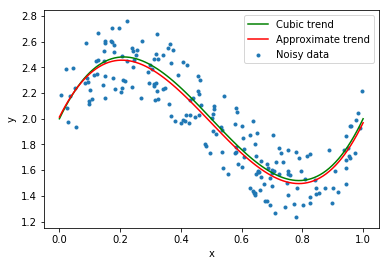

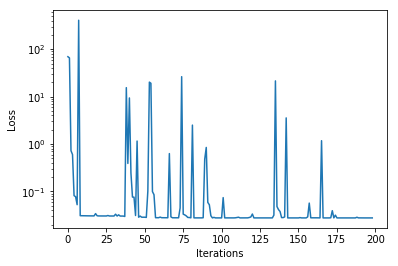

In [34]:
a = (rand()*2-1)*10
b = (rand()*2-1)*10
c = (rand()*2-1)*10
d = (rand()*2-1)*10

y = cubic(X, a, b, c, d)

s = 0.01
tol = 1.0e-8

lossCurrent = loss(N, y, X, Y)
lossList = [lossCurrent]

for k in range(0, 1000):
    aDer = aDerivative(N, y, X, Y)
    bDer = bDerivative(N, y, X, Y)
    cDer = cDerivative(N, y, X, Y)
    dDer = dDerivative(N, y, X, Y)
    
    aDerAbs = abs(aDer)
    bDerAbs = abs(bDer)
    cDerAbs = abs(cDer)
    dDerAbs = abs(dDer)
    
    # Barzilai-Borwein
    if k>0:
        num = (a-aOld)**2+(b-bOld)**2+(c-cOld)**2+(d-dOld)**2
        den = (a-aOld)*(aDer-aDerOld)+(b-bOld)*(bDer-bDerOld)+(c-cOld)*(cDer-cDerOld)+(d-dOld)*(dDer-dDerOld)
        s = num/den
    
    aNew = a - s*aDer
    bNew = b - s*bDer
    cNew = c - s*cDer
    dNew = d - s*dDer
    
    yNew = cubic(X, aNew, bNew, cNew, dNew)

    lossNew = loss(N, yNew, X, Y)

    aOld = a
    bOld = b
    cOld = c
    dOld = d
    
    a = aNew
    b = bNew
    c = cNew
    d = dNew
    y = yNew
        
    aDerOld = aDer
    bDerOld = bDer
    cDerOld = cDer
    dDerOld = dDer
    
    lossCurrent = lossNew
    lossList.append(lossCurrent)
    print(f"k = {k}. Loss = {lossNew}.")
    
    if aDerAbs<tol and bDerAbs<tol and cDerAbs<tol and dDerAbs<tol:
        break

print(f"\n True values: A = {A}, B = {B}, C = {C}, D = {D}.")
print(f"\n Approximate values: a = {a}, b = {b}, c = {c}, d = {d}.")

plt.scatter(X, Y, marker='.')
plt.plot(t, cubic(t, A, B, C, D), 'g')
plt.plot(t, cubic(t, a, b, c, d), 'r')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Cubic trend", "Approximate trend", "Noisy data"])

plt.figure()
plt.semilogy(range(0,len(lossList)),lossList)
plt.xlabel("Iterations")
plt.ylabel("Loss")

Beautiful convergence in just a few iterations!

Notice that the loss function does not decrease monotonically. This method is clearly doing something more complicated than simple descent. Remember this as a nice trick for the future.